## Import Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read file csv as a dataframe
filename = 'sorted_training_dataset_with_labels.csv'
raw_df = pd.read_csv(filename)

raw_df.head()

,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,patient_id,study_instance_uid,series_instance_uid,image_position,samples_per_pixel,pixel_spacing,pixel_representation,window_center,window_width,rescale_intercept,rescale_slope,ID
0,ID_45785016b.dcm,0,0,0,0,0,0,ID_0002cd41,ID_66929e09d4,ID_e22a5534e6,"[-125.000, -122.596, 35.968]",1,"[0.488281, 0.488281]",1,30,80,-1024.0,1.0,45785016b
1,ID_37f32aed2.dcm,0,0,0,0,0,0,ID_0002cd41,ID_66929e09d4,ID_e22a5534e6,"[-125.000, -122.596, 38.484]",1,"[0.488281, 0.488281]",1,30,80,-1024.0,1.0,37f32aed2
2,ID_1b9de2922.dcm,0,0,0,0,0,0,ID_0002cd41,ID_66929e09d4,ID_e22a5534e6,"[-125.000, -122.596, 41.000]",1,"[0.488281, 0.488281]",1,30,80,-1024.0,1.0,1b9de2922
3,ID_d61a6a7b9.dcm,0,0,0,0,0,0,ID_0002cd41,ID_66929e09d4,ID_e22a5534e6,"[-125.000, -122.596, 43.517]",1,"[0.488281, 0.488281]",1,30,80,-1024.0,1.0,d61a6a7b9
4,ID_406c82112.dcm,0,0,0,0,0,0,ID_0002cd41,ID_66929e09d4,ID_e22a5534e6,"[-125.000, -122.596, 46.033]",1,"[0.488281, 0.488281]",1,30,80,-1024.0,1.0,406c82112


## Patient Information - Study Instance

In [3]:
# Group by 'patient_id' and count the number of occurrences
patient_counts = raw_df.groupby('patient_id').size().reset_index(name='count')

# Display the number of patients
print('Number of patients:', len(patient_counts))

Number of patients: 18938


In [4]:
study_counts = raw_df.groupby('patient_id')['study_instance_uid'].nunique().reset_index(name='unique_study_count')

# Filter patients with more than one unique study_instance_uid
multiple_studies = study_counts[study_counts['unique_study_count'] > 1]

# Print the patient_id and the number of study_instance_uid's
print(multiple_studies)

        patient_id  unique_study_count
4      ID_000e5623                   2
12     ID_00257f20                   2
20     ID_00526c11                   2
44     ID_00a3b735                   4
61     ID_00d96858                   2
...            ...                 ...
18916  ID_ffadefb3                   6
18921  ID_ffc709c0                   8
18922  ID_ffc99fd6                   3
18925  ID_ffd4ab30                   2
18927  ID_ffd8dff8                   2

[1758 rows x 2 columns]


In [5]:
series_counts = (
    raw_df.groupby(['patient_id', 'study_instance_uid'])['series_instance_uid']
    .nunique()
    .reset_index(name='unique_series_count')
)

# Filter patients with more than one unique series_instance_uid
multiple_series = series_counts[series_counts['unique_series_count'] > 1]

# Print the result
print(multiple_series)

Empty DataFrame
Columns: [patient_id, study_instance_uid, unique_series_count]
Index: []


### Conclusion
- A single `patient_id` may be associated with multiple `study_instance_uid` entries.
- However, each `study_instance_uid` corresponds to only one unique `series_instance_uid`.

This indicates that while patients can have multiple studies, each study consists of a single series.

## Patient Information - Hemorrhage 

In [6]:
# Group by patient_id and study_instance_uid, and check if all hemorrhage types are 0
def classify_case(group):
    # Check if all hemorrhage types are 0
    if (group[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']] == 0).all().all():
        return 'Normal'
    else:
        return 'Abnormal'

# Group by patient_id and study_instance_uid
grouped = raw_df.groupby(['patient_id'])

# Apply the classification function to each group
classification = grouped.apply(classify_case)

# Convert the classification Series to a DataFrame
classification_df = classification.reset_index(name='case_type')

# Count the occurrences of normal and abnormal cases
case_counts = classification_df['case_type'].value_counts().reset_index()
case_counts.columns = ['case', 'count']

# Display the table of normal and abnormal counts
print("Table of Normal and Abnormal Counts:")
print(case_counts)

Table of Normal and Abnormal Counts:
       case  count
0    Normal  11286
1  Abnormal   7652


/tmp/ipykernel_33390/4097943997.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  classification = grouped.apply(classify_case)


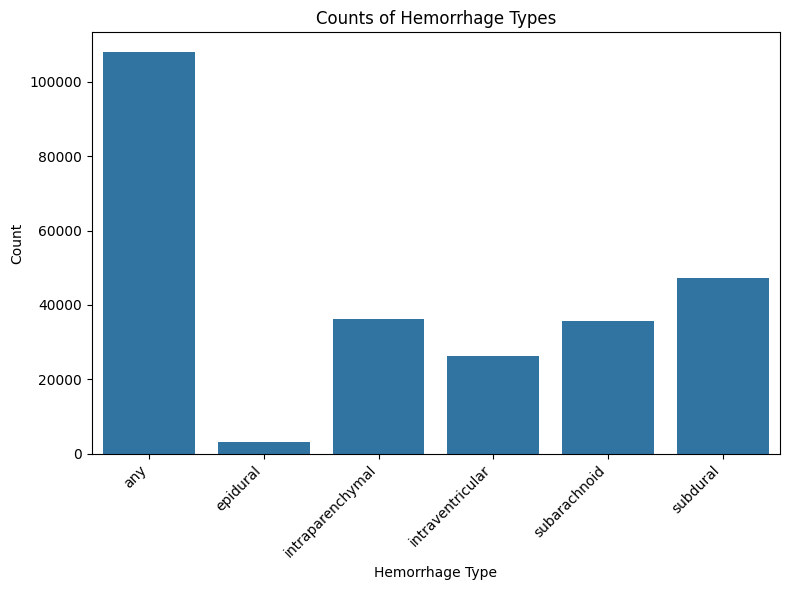

In [7]:
# Create a new DataFrame to count the number of occurrences for each hemorrhage type
hemorrhage_counts = raw_df[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].sum()

# Convert the Series to a DataFrame for plotting
hemorrhage_counts = hemorrhage_counts.reset_index()
hemorrhage_counts.columns = ['hemorrhage_type', 'count']

# Create the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='hemorrhage_type', y='count', data=hemorrhage_counts)
plt.title('Counts of Hemorrhage Types')
plt.xlabel('Hemorrhage Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Generate Scan Level Label

In [8]:
# Create a new DataFrame to count the number of occurrences for each hemorrhage type
scan_level_df = raw_df.groupby(['patient_id', 'study_instance_uid'])[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].max()

# Reset the index
scan_level_df = scan_level_df.reset_index()

# Get the columns to merge
# columns_to_merge = raw_df.columns.difference(scan_level_df.columns)

# Merge the columns
# scan_level_df = scan_level_df.merge(raw_df[columns_to_merge].drop_duplicates(subset=['patient_id', 'study_instance_uid']), on=['patient_id', 'study_instance_uid'], how='left')

scan_level_df.head()

,patient_id,study_instance_uid,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_0002cd41,ID_66929e09d4,0,0,0,0,0,0
1,ID_00054f3f,ID_8a449ae31b,0,0,0,0,0,0
2,ID_0006d192,ID_25690b4725,0,0,0,0,0,0
3,ID_00086119,ID_fdde2979b0,0,0,0,0,0,0
4,ID_000e5623,ID_9a4be35b9a,0,0,0,0,0,0


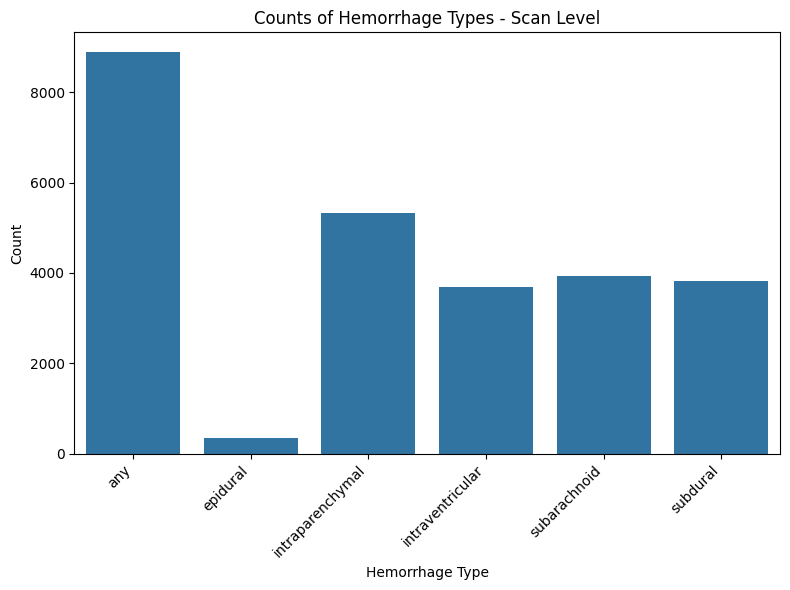

In [9]:
# Create a new DataFrame to count the number of occurrences for each hemorrhage type
hemorrhage_counts = scan_level_df[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].sum()

# Convert the Series to a DataFrame for plotting
hemorrhage_counts = hemorrhage_counts.reset_index()
hemorrhage_counts.columns = ['hemorrhage_type', 'count']

# Create the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='hemorrhage_type', y='count', data=hemorrhage_counts)
plt.title('Counts of Hemorrhage Types - Scan Level')
plt.xlabel('Hemorrhage Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [10]:
# Save to a new csv file
scan_level_df.to_csv('scan_level_dataset.csv', index=False)

## Copy first 1000 cases for training

In [11]:
import shutil
import os 

In [12]:
train_image_dir = './rsna-intracranial-hemorrhage-detection/stage_2_train'
destination_dir = './rsna-mil-training'
os.makedirs(destination_dir, exist_ok=True)

In [13]:
# Extract the first 1000 rows
scan_subset = scan_level_df.head(1000)

# Get patient_id and study_instance_uid
patient_ids = scan_subset['patient_id']
study_uids = scan_subset['study_instance_uid']

In [16]:
# Save scan_subset to a new csv file
scan_subset.to_csv('training_1000_scan_subset.csv', index=False)

In [14]:
# Initialize a list to hold filenames
filenames_to_copy = []

# Iterate through the extracted patient IDs and study UIDs
for patient_id, study_uid in zip(patient_ids, study_uids):
    matching_files = raw_df[(raw_df['patient_id'] == patient_id) & 
                            (raw_df['study_instance_uid'] == study_uid)]
    # Append the filenames to the list
    filenames_to_copy.extend(matching_files['filename'].tolist())

In [15]:
for index, row in scan_subset.iterrows():
    patient_id = row['patient_id']
    study_instance_uid = row['study_instance_uid']
    
    # Remove 'ID_' prefix from patient_id and study_instance_uid
    patient_id_clean = patient_id.replace('ID_', '')
    study_instance_uid_clean = study_instance_uid.replace('ID_', '')

    # Create the subdirectory name without the 'ID_' prefix
    subdirectory_name = f"{patient_id_clean}_{study_instance_uid_clean}"

    subdirectory_path = os.path.join(destination_dir, subdirectory_name)
    os.makedirs(subdirectory_path, exist_ok=True)
    
    # Filter raw_df for matching patient_id and study_instance_uid
    matching_files = raw_df[(raw_df['patient_id'] == patient_id) & 
                             (raw_df['study_instance_uid'] == study_instance_uid)]
    
    # Copy each matching file to the subdirectory
    for _, file_row in matching_files.iterrows():
        filename = file_row['filename']
        source_file_path = os.path.join(train_image_dir, filename)
        destination_file_path = os.path.join(subdirectory_path, filename)
        
        # Copy the file
        shutil.copy(source_file_path, destination_file_path)

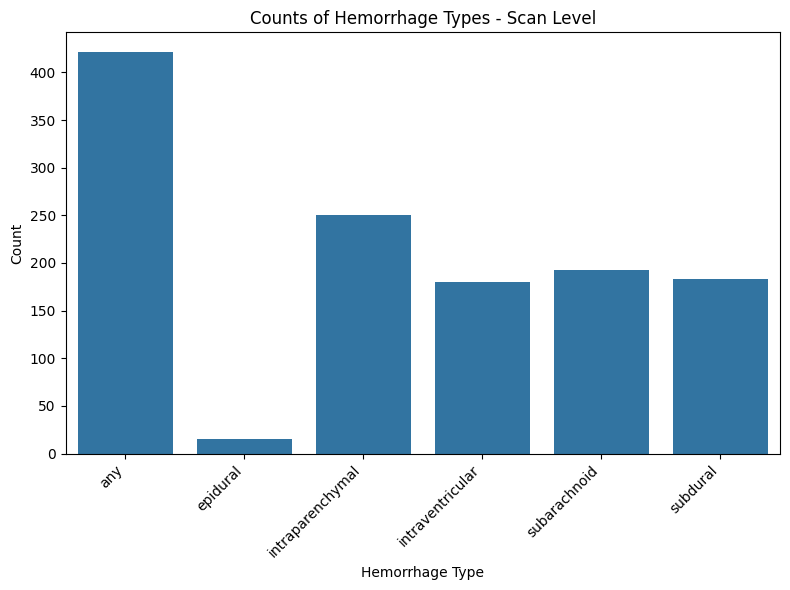

In [17]:
# Create a new DataFrame to count the number of occurrences for each hemorrhage type
hemorrhage_counts = scan_subset[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].sum()

# Convert the Series to a DataFrame for plotting
hemorrhage_counts = hemorrhage_counts.reset_index()
hemorrhage_counts.columns = ['hemorrhage_type', 'count']

# Create the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='hemorrhage_type', y='count', data=hemorrhage_counts)
plt.title('Counts of Hemorrhage Types - Scan Level')
plt.xlabel('Hemorrhage Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()